In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display

# 街景分割 (pytorch)

支援python 版本: 3.5以上    
支援pytorch版本 : 1.2以上

許多人小時候都曾經幻想過自己是霹靂遊俠的李麥克，能夠有一台自動駕駛的「夥計」，而如今這個夢想已經不算是太遙遠，我們今天要做的實作就是教各位如何賦予汽車視覺，最普遍的做法是透過分割模型，將機器視野的圖片進行分割，並且針對各區域進行識別，這樣汽車才知道路在那裏，哪裡有行人得小心注意。下圖是我們這次實作所使用的原圖以及標注結果。 

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models.pytorch_densenet import DenseNetFcn


trident 0.4.3
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.4.0.


這次採用的數據集是Cambridge-driving Labeled Video Database (http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/ )，他實際上就是真實的汽車駕駛過程的街景，裏面包含了原圖已經標註的遮罩圖(mask)。

<img src="../images/streetview_image.png">
<img src="../images/streetview_mask.png">

In [3]:
dataset=load_examples_data('autodrive')
dataset.paired_transform_funcs=[random_rescale_crop(224, 224,scale=(0.3,1.1))]
dataset.image_transform_funcs=[
                     add_noise(0.01),
                     random_adjust_gamma(gamma=(0.8,1.2)),
                     random_adjust_contast(scale=(0.9, 1.1)),
                     normalize(0,255),
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
get autodrive images :701


所有標注類別對應的顏色，紀錄在label_colors.txt中(可以在~\.trident\datasets\examples_autodrive目錄下找到)，我們讀取出來並且產生定義清單。這邊顏色的排序為(R,G,B)，與我們的圖片標準一致，若是您另外使用opencv處理數據，則需要自行轉換順序，例如路面上的汽車是紫色，opencv的BGR應該是(128,0,64)。在trident api中，Mask類的數據來源有專用的MaskDataset，它可以處理二元遮罩、標籤遮罩(基於索引值區分類別)以及色彩遮罩(基於顏色區分類別)，在這個範例中正是色彩遮罩，透過MaskDataset讀取色彩遮罩圖片，會自動處理將它轉換為對於建模有用的標籤遮罩。自動處理主要是調用了trident.data.mask_common中的color2label以及label2color函數。

In [4]:
print(dataset.traindata.palette)

OrderedDict([('Void', (0, 0, 0)), ('Building', (128, 0, 0)), ('Tree', (128, 128, 0)), ('Sky', (128, 128, 128)), ('Car', (64, 0, 128)), ('Archway', (192, 0, 128)), ('SignSymbol', (192, 128, 128)), ('Road', (128, 64, 128)), ('Pedestrian', (64, 64, 0)), ('Wall', (64, 192, 0)), ('VegetationMisc', (192, 192, 0)), ('Fence', (64, 64, 128)), ('Train', (192, 64, 128)), ('ParkingBlock', (64, 192, 128)), ('Column_Pole', (192, 192, 128)), ('TrafficCone', (0, 0, 64)), ('Bridge', (0, 128, 64)), ('Misc_Text', (128, 128, 64)), ('Sidewalk', (0, 0, 192)), ('LaneMkgsDriv', (128, 0, 192)), ('Bicyclist', (0, 128, 192)), ('RoadShoulder', (128, 128, 192)), ('Tunnel', (64, 0, 64)), ('LaneMkgsNonDriv', (192, 0, 64)), ('Animal', (64, 128, 64)), ('Child', (192, 128, 64)), ('CartLuggagePram', (64, 0, 192)), ('MotorcycleScooter', (192, 0, 192)), ('SUVPickupTruck', (64, 128, 192)), ('Truck_Bus', (192, 128, 192)), ('TrafficLight', (0, 64, 64)), ('OtherMoving', (128, 64, 64))])


定義fcn-densenet，也就是俗稱的提拉米蘇。基本上它是以Densenet為基礎，總共包含兩個路徑，一個是逐步進行下採樣讓圖片縮小(TD,  transition down)，另外一個路徑則是逐步將縮小的圖片進行上採樣來復原(TU, transition up)，在尺寸對應的的層，會透過skip connection將較完整清晰的特徵從TD路徑傳至TU路徑，以確保細節特徵的完整性。

<img src="../images/dense_connection.png">

<img src="../images/tiramisu.jpg">

由於我們這次並沒有使用預訓練模型來做微調，必須從零開始，那意味著我們需要花更多的訓練資源才能做到一樣的效果，但我們這次又有一個限制是數據集只有701張圖片，在沒有預訓練又圖片數量少(還好圖片標註品質很好)，就必須從模型結構設計下手才有可能做到較好的預測效果。以下是我針對這樣的情況做的一些調整：  
1. 使用DenseNetFcn就是一個較佳的選擇，因為DenseNet強調的是特徵的重複使用，整個網路中不斷地進行特徵篩選、特徵重新加入，以及各種尺度特徵的混合，所以利用這樣的網路結構比較不容易發生過擬合。  
2. 過擬合很容易發生的一個主因是使用了與數據不相襯的參數規模，尤其是越複雜(參數越多的網路)只能靠更龐大的數據集才有可能訓練的好，也因此，原始論文的tiramisu 103的blocks參數是(4,5,7,10,12,15)我把它下調到(4, 5, 6, 7, 8)，原本原始參數TransitionDown共使用了5次(len(blocks)-1)，我則是使用4次，然後讓第一層的卷積透過strides=2分擔掉一次下採樣的任務，這樣也可以減少非常大量的計算量。
3. 原本的TransitionDown是利用一個3x3常規卷積搭配MaxPool，基本上我們課程介紹過，使用池化是比較古老的做法了，現在都建議使用Strides=2來替代池化。此外，為了降低計算量，我把常規卷積置換為Depthwise卷積，也可以大幅縮小計算的參數數量。同時也加入了0.2的dropout，以增加模型的強健程度避免過擬合。
4. 數據增強中把random_center_crop換成了random_rescale_crop，在之前實作「去背神器」中是一個二分類的分割模型，因此如果crop剛好沒有人的出現就會影響訓練，所以使用random_center_crop來確保人會出現在取數的範圍。但是現在這是一個32分類的問題，基本上不管切到哪裡都會有要預測的類別，使用random_rescale_crop的好處在於可以聚焦在不同的區域而非僅是中心點，這樣可以保證取出來的結果的多元性，有可以緩解模型總是預測最大積率類別的問題。
5. 使用了多損失函數策略。一開始先用DiceLoss這種基於類別的損失函數來達到快速的損失下降(多分類的DiceLoss是計算每個類別的損失後平均，因此本身是不易受到分布不均衡影響)，但是DiceLoss雖然能讓整體模型有快速收斂的效果，卻無法作精細的調整，所以還需要同時加入損失函數CrossEntropyLoss來做細部的調整，但由於CrossEntropyLoss是計算每顆像素的CrossEntropyLoss後平均，因此會嚴重受到類別不均衡的影響。所以最後在第5個epoch後加入FocalLoss，來處理最後類別不均衡的分類錯誤。這樣分層次的多損失函數策略可以讓模型分階段調整，以確保模型整體效果。
6. 學習速率一開始就使用偏小的5e-4，確保收斂不至於衝太快避免掉入區域最佳解的問題。


In [5]:
tiramisu=DenseNetFcn(blocks=(4, 5, 6, 7, 8),growth_rate=16, initial_filters=32,num_classes=32)

#tiramisu.load_model('Models/tiramisu.pth.tar')

In [6]:
tiramisu.with_optimizer(optimizer='Ranger',lr=5e-4,betas=(0.9, 0.999))\
    .with_loss(DiceLoss)\
    .with_loss(CrossEntropyLoss)\
    .with_loss(FocalLoss,2,start_epoch=5)\
    .with_metric(pixel_accuracy,name='pixel_accuracy')\
    .with_metric(iou,name='iou')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='iou',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_model_save_path('Models/tiramisu.pth')\
    .with_callbacks(SegTileImageCallback(batch_inteval=20,reverse_image_transform=dataset.reverse_image_transform,palette=dataset.traindata.palette))

#在模型中設定
#with_optimizer 設定優化器為Ranger
#with_loss(DiceLoss) 加入Dice loss損失函數(類別層級)
#with_loss(CrossEntropyLoss)加入交叉熵作為損失函數(像素層級)
#with_loss(FocalLoss,start_epoch=5)加入FocalLoss作為損失函數(像素層級)解決類別不均衡問題，於epoch=5時開始納入計算
#with_metric(pixel_accuracy) 加入像素正確率metrics
#with_metric(iou,name='iou') 加入iou作為metrics
#with_regularizer('l2')\ 加入l2正則
#with_constraint('max_min_norm')\ 加入max_min_norm權重正則
#with_learning_rate_scheduler(reduce_lr_on_plateau) 加入reduce_lr_on_plateau學習率變化原則(指標不再變動時，學習率下降)
#with_model_save_path('Models/deeplab_seg.pth') 設定模型存檔路徑
#with_callbacks 加入SegTileImageCallback來繪製比較用的tile images

tiramisu.summary()

DiceLoss signature:['output', 'target']
CrossEntropyLoss signature:['output', 'target']
FocalLoss signature:['output', 'target']
pixel_accuracy signature:['output', 'target']
iou signature:['output', 'target']
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_layer.conv                         [-1, 32, 112, 112]    [32, 3, 3, 3]                  864       21663488.0  
first_layer.norm                         [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
first_layer                              [-1, 32, 112, 112]                                   0         0.0         
denseblock_down1.denselayer1.norm        [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
denseblock_down1.denselayer1.relu        [-1, 32, 112, 112]                 

bottleneck.denselayer1                   [-1, 16, 7, 7]                                       0         0.0         
bottleneck.denselayer2.norm              [-1, 112, 7, 7]       [112]                [112]     224       16415.0     
bottleneck.denselayer2.relu              [-1, 112, 7, 7]                                      0         0.0         
bottleneck.denselayer2.conv1.conv        [-1, 64, 7, 7]        [64, 112, 1, 1]                7168      702415.0    
bottleneck.denselayer2.conv1.norm        [-1, 64, 7, 7]        [64]                 [64]      128       9359.0      
bottleneck.denselayer2.conv1             [-1, 64, 7, 7]                                       0         0.0         
bottleneck.denselayer2.conv2             [-1, 16, 7, 7]        [16, 64, 3, 3]                 9216      903119.0    
bottleneck.denselayer2                   [-1, 16, 7, 7]                                       0         0.0         
bottleneck.denselayer3.norm              [-1, 128, 7, 7]       [

denseblock_up2.denselayer4.conv1.conv    [-1, 64, 56, 56]      [64, 304, 1, 1]                19456     122024896.0 
denseblock_up2.denselayer4.conv1.norm    [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
denseblock_up2.denselayer4.conv1         [-1, 64, 56, 56]                                     0         0.0         
denseblock_up2.denselayer4.conv2         [-1, 16, 56, 56]      [16, 64, 3, 3]                 9216      57799616.0  
denseblock_up2.denselayer4               [-1, 16, 56, 56]                                     0         0.0         
denseblock_up2.denselayer5.norm          [-1, 320, 56, 56]     [320]                [320]     640       3007424.0   
denseblock_up2.denselayer5.relu          [-1, 320, 56, 56]                                    0         0.0         
denseblock_up2.denselayer5.conv1.conv    [-1, 64, 56, 56]      [64, 320, 1, 1]                20480     128447424.0 
denseblock_up2.denselayer5.conv1.norm    [-1, 64, 56, 56]      [

In [7]:
plan=TrainingPlan()\
    .add_training_item(tiramisu,name='tiramisu')\
    .with_data_loader(dataset)\
    .repeat_epochs(15)\
    .within_minibatch_size(6)\
    .print_progress_scheduling(5,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=50,unit='batch',imshow=True)\
    .save_model_scheduling(20,unit='batch')\

#add_training_item加入要訓練的模型
#with_data_loader加入數據提供者
#repeat_epochs設定要執行的epoch數量
#within_minibatch_size設定minibatch_size
#print_progress_scheduling設定列印進度的頻率
#display_loss_metric_curve_scheduling設定顯示損失函數曲線的頻率
#save_model_scheduling設定存檔的頻率

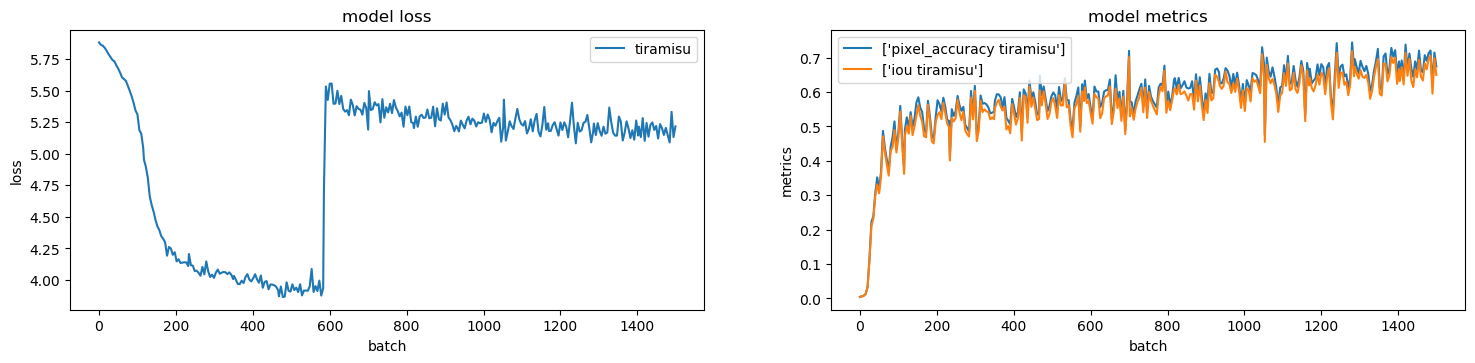

tiramisu     Step: 32s344ms | Loss: 5.051   | pixel_accuracy: 76.478% ,iou: 75.123%  | learning rate: 5.000e-04 | epoch: 12  ( 100/117 )


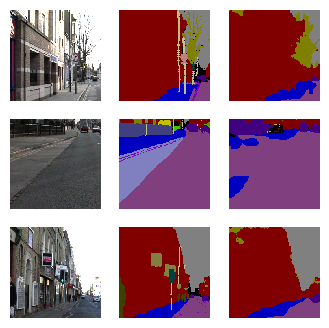

tiramisu     Step: 33s723ms | Loss: 5.182   | pixel_accuracy: 67.480% ,iou: 66.036%  | learning rate: 5.000e-04 | epoch: 12  ( 105/117 )
tiramisu     Step: 31s270ms | Loss: 5.125   | pixel_accuracy: 73.880% ,iou: 70.540%  | learning rate: 5.000e-04 | epoch: 12  ( 110/117 )
tiramisu     Step: 27s621ms | Loss: 5.046   | pixel_accuracy: 77.031% ,iou: 74.867%  | learning rate: 5.000e-04 | epoch: 12  ( 115/117 )
tiramisu     Step: 10s95ms  | Loss: 5.185   | pixel_accuracy: 66.244% ,iou: 64.629%  | learning rate: 5.000e-04 | epoch: 13  ( 0/117 )
OrderedDict([('total_losses', 5.185396909713745), ('DiceLoss', 0.4772290587425232), ('CrossEntropyLoss', 3.1607444286346436), ('l2_reg_Loss', 5.700233941752231e-06), ('FocalLoss', 1.4803149700164795)])


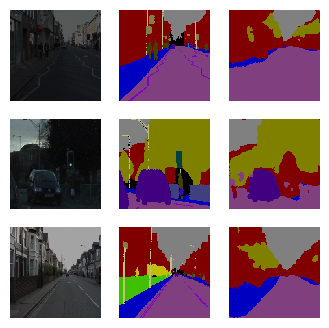

tiramisu     Step: 28s988ms | Loss: 5.119   | pixel_accuracy: 73.807% ,iou: 71.572%  | learning rate: 5.000e-04 | epoch: 13  ( 5/117 )
tiramisu     Step: 26s514ms | Loss: 5.103   | pixel_accuracy: 70.857% ,iou: 69.739%  | learning rate: 5.000e-04 | epoch: 13  ( 10/117 )
tiramisu     Step: 26s801ms | Loss: 5.081   | pixel_accuracy: 75.799% ,iou: 72.484%  | learning rate: 5.000e-04 | epoch: 13  ( 15/117 )
tiramisu     Step: 25s565ms | Loss: 5.207   | pixel_accuracy: 68.660% ,iou: 66.454%  | learning rate: 5.000e-04 | epoch: 13  ( 20/117 )


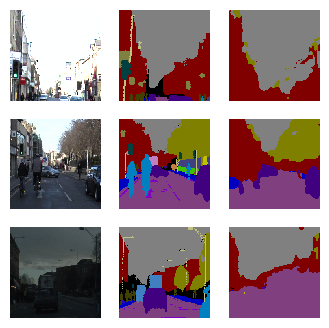

tiramisu     Step: 26s921ms | Loss: 5.169   | pixel_accuracy: 69.886% ,iou: 67.785%  | learning rate: 5.000e-04 | epoch: 13  ( 25/117 )
tiramisu     Step: 25s750ms | Loss: 5.248   | pixel_accuracy: 67.859% ,iou: 63.086%  | learning rate: 5.000e-04 | epoch: 13  ( 30/117 )
tiramisu     Step: 25s329ms | Loss: 5.256   | pixel_accuracy: 66.362% ,iou: 64.109%  | learning rate: 5.000e-04 | epoch: 13  ( 35/117 )
tiramisu     Step: 24s941ms | Loss: 5.162   | pixel_accuracy: 72.982% ,iou: 67.742%  | learning rate: 5.000e-04 | epoch: 13  ( 40/117 )


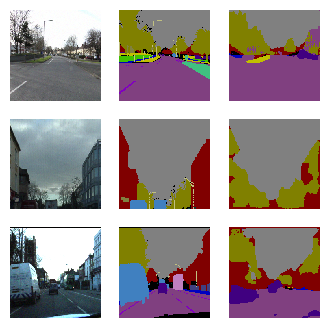

tiramisu     Step: 53s312ms | Loss: 5.160   | pixel_accuracy: 70.357% ,iou: 68.139%  | learning rate: 5.000e-04 | epoch: 13  ( 45/117 )


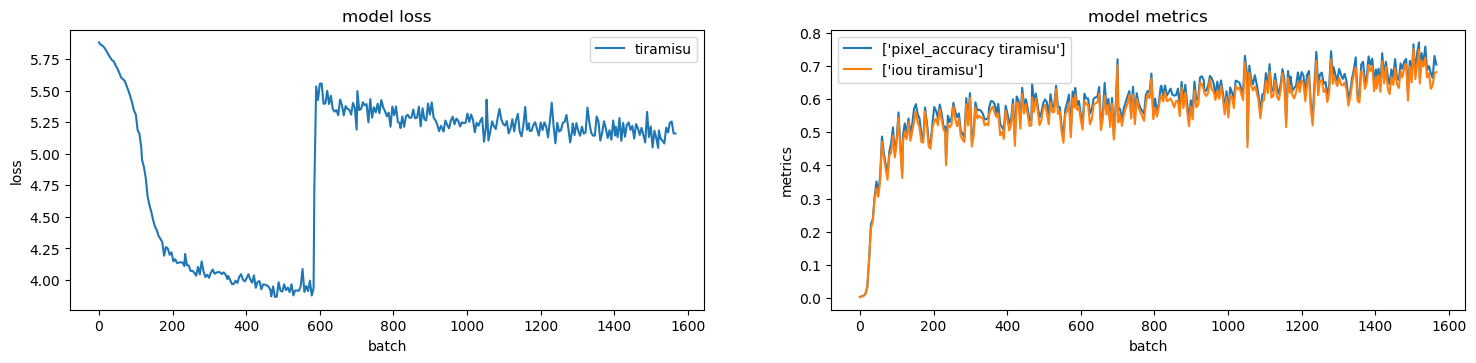

tiramisu     Step: 27s518ms | Loss: 5.185   | pixel_accuracy: 70.638% ,iou: 68.261%  | learning rate: 5.000e-04 | epoch: 13  ( 50/117 )
tiramisu     Step: 25s517ms | Loss: 5.117   | pixel_accuracy: 71.915% ,iou: 69.226%  | learning rate: 5.000e-04 | epoch: 13  ( 55/117 )
tiramisu     Step: 26s515ms | Loss: 5.224   | pixel_accuracy: 68.054% ,iou: 63.795%  | learning rate: 5.000e-04 | epoch: 13  ( 60/117 )


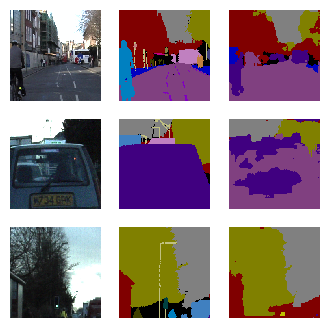

tiramisu     Step: 27s471ms | Loss: 5.124   | pixel_accuracy: 72.154% ,iou: 69.799%  | learning rate: 5.000e-04 | epoch: 13  ( 65/117 )
tiramisu     Step: 26s182ms | Loss: 5.200   | pixel_accuracy: 68.488% ,iou: 66.461%  | learning rate: 5.000e-04 | epoch: 13  ( 70/117 )
tiramisu     Step: 25s36ms  | Loss: 5.139   | pixel_accuracy: 73.774% ,iou: 69.675%  | learning rate: 5.000e-04 | epoch: 13  ( 75/117 )
tiramisu     Step: 34s423ms | Loss: 5.063   | pixel_accuracy: 73.900% ,iou: 72.495%  | learning rate: 5.000e-04 | epoch: 13  ( 80/117 )


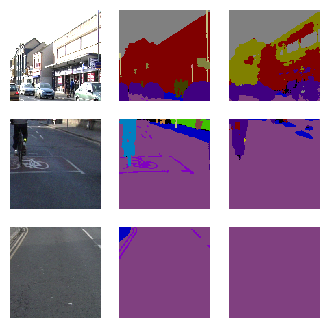

tiramisu     Step: 46s984ms | Loss: 5.193   | pixel_accuracy: 67.959% ,iou: 65.979%  | learning rate: 5.000e-04 | epoch: 13  ( 85/117 )
tiramisu     Step: 42s908ms | Loss: 5.187   | pixel_accuracy: 70.225% ,iou: 68.174%  | learning rate: 5.000e-04 | epoch: 13  ( 90/117 )
tiramisu     Step: 44s374ms | Loss: 5.097   | pixel_accuracy: 76.432% ,iou: 73.304%  | learning rate: 5.000e-04 | epoch: 13  ( 95/117 )


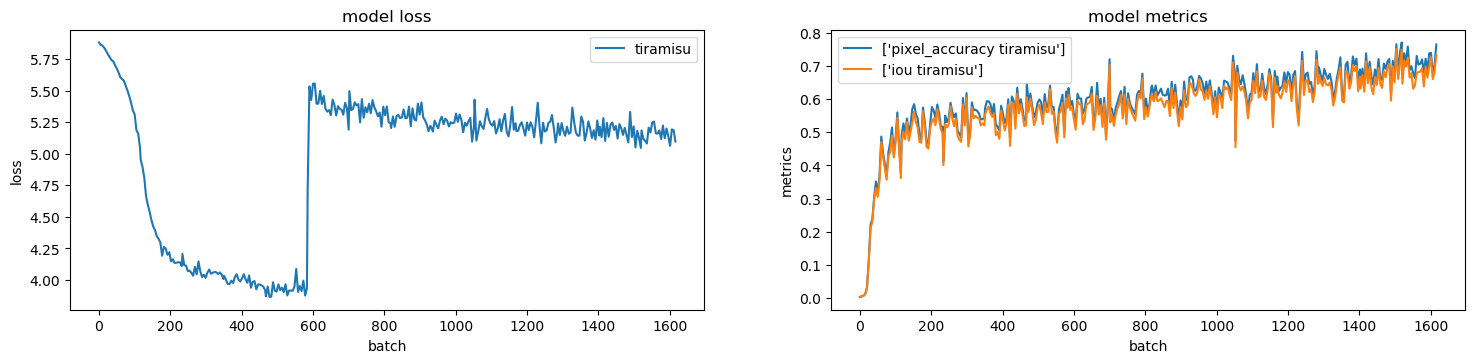

tiramisu     Step: 47s645ms | Loss: 5.116   | pixel_accuracy: 74.989% ,iou: 72.375%  | learning rate: 5.000e-04 | epoch: 13  ( 100/117 )


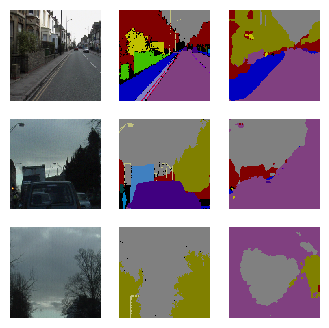

tiramisu     Step: 47s298ms | Loss: 5.157   | pixel_accuracy: 69.353% ,iou: 67.306%  | learning rate: 5.000e-04 | epoch: 13  ( 105/117 )
tiramisu     Step: 41s883ms | Loss: 5.055   | pixel_accuracy: 79.247% ,iou: 75.586%  | learning rate: 5.000e-04 | epoch: 13  ( 110/117 )
tiramisu     Step: 43s517ms | Loss: 5.225   | pixel_accuracy: 65.769% ,iou: 64.409%  | learning rate: 5.000e-04 | epoch: 13  ( 115/117 )
tiramisu     Step: 16s908ms | Loss: 5.022   | pixel_accuracy: 76.457% ,iou: 74.344%  | learning rate: 5.000e-04 | epoch: 14  ( 0/117 )
OrderedDict([('total_losses', 5.022104740142822), ('DiceLoss', 0.4005413353443146), ('CrossEntropyLoss', 3.0837161540985107), ('l2_reg_Loss', 5.701383997802623e-06), ('FocalLoss', 1.4708185195922852)])


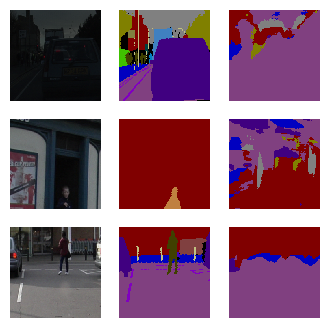

tiramisu     Step: 46s489ms | Loss: 5.199   | pixel_accuracy: 69.803% ,iou: 66.756%  | learning rate: 5.000e-04 | epoch: 14  ( 5/117 )
tiramisu     Step: 44s488ms | Loss: 5.180   | pixel_accuracy: 68.182% ,iou: 66.255%  | learning rate: 5.000e-04 | epoch: 14  ( 10/117 )
tiramisu     Step: 42s201ms | Loss: 5.107   | pixel_accuracy: 74.287% ,iou: 71.382%  | learning rate: 5.000e-04 | epoch: 14  ( 15/117 )
tiramisu     Step: 44s948ms | Loss: 5.170   | pixel_accuracy: 71.806% ,iou: 68.262%  | learning rate: 5.000e-04 | epoch: 14  ( 20/117 )


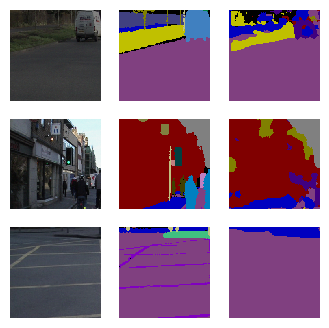

tiramisu     Step: 48s166ms | Loss: 5.066   | pixel_accuracy: 75.773% ,iou: 74.205%  | learning rate: 5.000e-04 | epoch: 14  ( 25/117 )
tiramisu     Step: 43s738ms | Loss: 5.108   | pixel_accuracy: 74.258% ,iou: 71.047%  | learning rate: 5.000e-04 | epoch: 14  ( 30/117 )
tiramisu     Step: 41s453ms | Loss: 5.154   | pixel_accuracy: 70.831% ,iou: 68.516%  | learning rate: 5.000e-04 | epoch: 14  ( 35/117 )
tiramisu     Step: 37s882ms | Loss: 5.068   | pixel_accuracy: 75.827% ,iou: 72.916%  | learning rate: 5.000e-04 | epoch: 14  ( 40/117 )


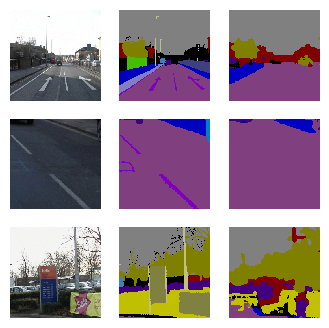

tiramisu     Step: 46s218ms | Loss: 5.134   | pixel_accuracy: 71.319% ,iou: 69.133%  | learning rate: 5.000e-04 | epoch: 14  ( 45/117 )


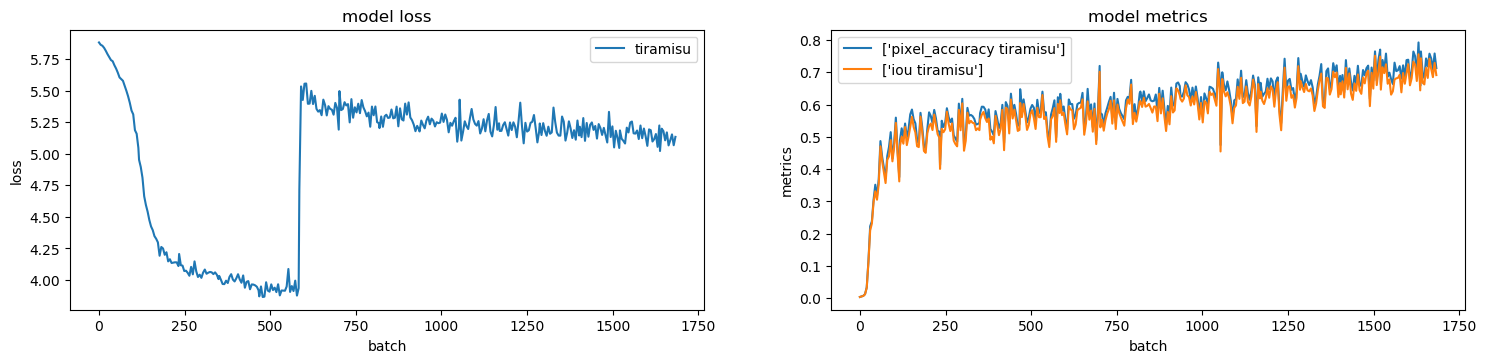

tiramisu     Step: 49s105ms | Loss: 5.043   | pixel_accuracy: 74.898% ,iou: 72.892%  | learning rate: 5.000e-04 | epoch: 14  ( 50/117 )
tiramisu     Step: 1m17s    | Loss: 5.159   | pixel_accuracy: 70.822% ,iou: 68.875%  | learning rate: 5.000e-04 | epoch: 14  ( 55/117 )
tiramisu     Step: 54s916ms | Loss: 5.149   | pixel_accuracy: 72.687% ,iou: 68.560%  | learning rate: 5.000e-04 | epoch: 14  ( 60/117 )


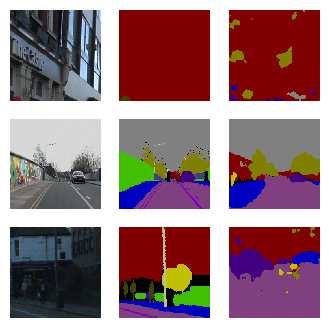

tiramisu     Step: 54s569ms | Loss: 5.115   | pixel_accuracy: 70.186% ,iou: 67.556%  | learning rate: 5.000e-04 | epoch: 14  ( 65/117 )
tiramisu     Step: 51s563ms | Loss: 5.148   | pixel_accuracy: 72.148% ,iou: 70.005%  | learning rate: 5.000e-04 | epoch: 14  ( 70/117 )
tiramisu     Step: 50s174ms | Loss: 5.152   | pixel_accuracy: 74.195% ,iou: 69.225%  | learning rate: 5.000e-04 | epoch: 14  ( 75/117 )
tiramisu     Step: 48s852ms | Loss: 5.117   | pixel_accuracy: 73.438% ,iou: 70.667%  | learning rate: 5.000e-04 | epoch: 14  ( 80/117 )


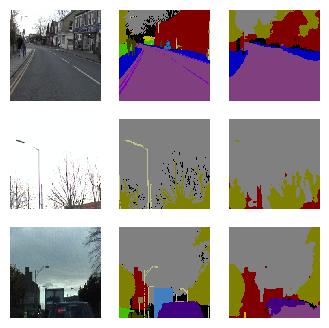

tiramisu     Step: 55s358ms | Loss: 5.249   | pixel_accuracy: 65.955% ,iou: 63.710%  | learning rate: 5.000e-04 | epoch: 14  ( 85/117 )
tiramisu     Step: 47s397ms | Loss: 5.082   | pixel_accuracy: 75.062% ,iou: 73.538%  | learning rate: 5.000e-04 | epoch: 14  ( 90/117 )
tiramisu     Step: 44s285ms | Loss: 5.268   | pixel_accuracy: 65.070% ,iou: 63.735%  | learning rate: 5.000e-04 | epoch: 14  ( 95/117 )


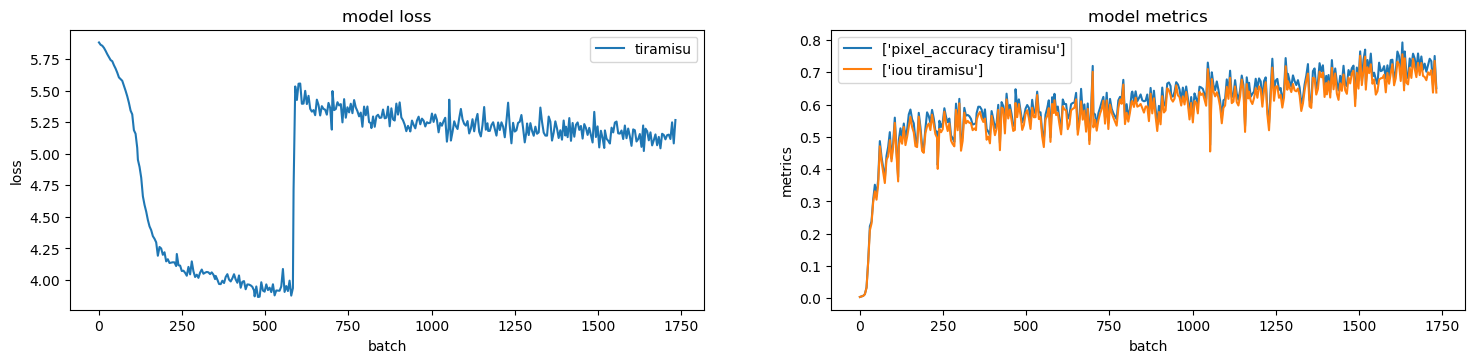

tiramisu     Step: 49s285ms | Loss: 5.143   | pixel_accuracy: 71.952% ,iou: 69.443%  | learning rate: 5.000e-04 | epoch: 14  ( 100/117 )


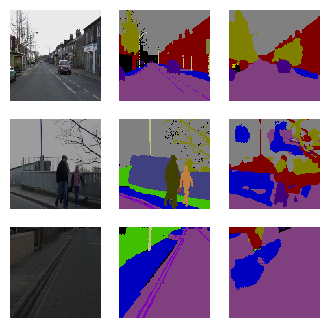

tiramisu     Step: 49s202ms | Loss: 5.073   | pixel_accuracy: 76.556% ,iou: 73.939%  | learning rate: 5.000e-04 | epoch: 14  ( 105/117 )
tiramisu     Step: 44s995ms | Loss: 5.072   | pixel_accuracy: 75.119% ,iou: 72.566%  | learning rate: 5.000e-04 | epoch: 14  ( 110/117 )
tiramisu     Step: 45s423ms | Loss: 5.082   | pixel_accuracy: 74.493% ,iou: 71.962%  | learning rate: 5.000e-04 | epoch: 14  ( 115/117 )


In [8]:
plan.start_now()